In [1]:
from spacy import load
model = load('en_core_web_sm')
print('loaded spacy model')

loaded spacy model


In [2]:
import pandas as pd
from ast import literal_eval
df = pd.read_csv(filepath_or_buffer='/kaggle/input/inshorts-dataset-english/english_news_dataset.csv', parse_dates=['Date'], dayfirst=True)
df['headline'] = df['Headline'].str.lower()
df['category'] = df['News Categories'].apply(func=lambda x: literal_eval(x)[0])
df.head()

,Headline,Content,News Categories,Date,headline,category
0,Congress leader Baljinder Singh shot dead at h...,Congress leader Baljinder Singh was shot dead ...,['national'],19-09-2023,congress leader baljinder singh shot dead at h...,national
1,17-year-old girl preparing for NEET dies by su...,Another NEET aspirant died by suicide in Rajas...,['national'],19-09-2023,17-year-old girl preparing for neet dies by su...,national
2,Hampers to welcome MPs in new Parliament tomor...,In order to mark the first-ever working day of...,['national'],19-09-2023,hampers to welcome mps in new parliament tomor...,national
3,"Only 10% women lawmakers in RS, while only 14%...","Congress President Mallikarjun Kharge, while s...",['national'],19-09-2023,"only 10% women lawmakers in rs, while only 14%...",national
4,"Ganesh temple decorated with notes, coins wort...",The Sri Sathya Ganapathi Temple in Bengaluru a...,['national'],19-09-2023,"ganesh temple decorated with notes, coins wort...",national


Add a category field for our headlines/articles, and add a lowercase headline column.

In [3]:
from arrow import now
time_start = now()
nouns = []
for index, headline in enumerate(df['headline'].values.tolist()):
    tokens = model(headline)
    for token in tokens:
        if token.pos_ in {'NOUN', 'PROPN'}:
            nouns.append(token.text)
    if index > 0 and index % 10000 == 0:
        print('{} : count: {}'.format(now(), len(nouns)))
nouns = set(nouns)
print('{} : unique : {}'.format(now(), len(nouns)))
print(now() - time_start)

2023-10-09T20:02:22.824233+00:00 : count: 55037
2023-10-09T20:03:29.686436+00:00 : count: 109900
2023-10-09T20:04:36.279054+00:00 : count: 164929
2023-10-09T20:05:42.711370+00:00 : count: 220887
2023-10-09T20:06:20.890433+00:00 : unique : 7817
0:05:06.588682


Get all the nouns using the parts-of-speech model; this takes a while, maybe five or six minutes.

In [4]:
# do some manual touch-ups
nouns = {noun for noun in nouns if noun not in {'cr', 'in'}}

Remove a couple of special cases.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_tfidf(arg_df: pd.DataFrame, column: str):
    min_df = 10
    tfidf = TfidfVectorizer(min_df=min_df, vocabulary=nouns)
    tfidf_result = tfidf.fit_transform(raw_documents=[item for item in arg_df[column].fillna('').values.tolist() if item != ''])
    tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns = tfidf.get_feature_names_out()).sum(axis=0).to_frame().reset_index().rename(columns={'index': 'token', 0 : 'tfidf'})
    return tfidf_df, tfidf_result, tfidf.get_feature_names_out()
print('built get tfidf')

built get tfidf


Use only the nouns as vocabulary to build the tf-idf model so our tf-idf data contains only nouns.

In [6]:
from plotly.express import scatter
from sklearn.decomposition import PCA

def startswith_type(char: str) -> str:
    if char in list('1234567890'):
        return 'number' 
    if char in list('aeiouy'):
        return 'vowel' 
    return 'consonant'

tfidf_df, tfidf_result, tfidf_features = get_tfidf(arg_df=df, column='headline')
tfidf_df['startswith'] = tfidf_df['token'].str[0]
tfidf_df['startswith_type'] = tfidf_df['startswith'].apply(func=startswith_type)
tfidf_df['noun'] = tfidf_df['token'].isin(nouns)

pca = PCA(n_components=3, copy=True, random_state=2023)
pca_result = pca.fit_transform(X=tfidf_result.toarray().transpose())
tfidf_df[['pca1', 'pca2', 'pca3']] = pca_result

scatter(data_frame=tfidf_df, x='pca3', y='tfidf', hover_name='token', log_x=True, log_y=True, color='pca1',
        title='Headline relevance plot').show()

We have one kind of data: the tf-idf relevance, so we use the PCA to try to get a second dimension that will let us plot the tokens.

In [7]:
from plotly.express import strip
strip(data_frame=tfidf_df, y='tfidf', hover_name='token', log_y=True, x='startswith',)

We can also plot the data with a strip plot using the initial character. It also looks neat but is not full of information.

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(verbose=1, random_state=2023, n_components=15, max_iter=15, )
time_start = now()
lda_result = lda.fit_transform(X=tfidf_result)
print(now() - time_start)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
0:00:53.883651


Fifteen iterations take about a minute.

In [9]:
# copied from 
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(30, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
print('built plot top words')

built plot top words


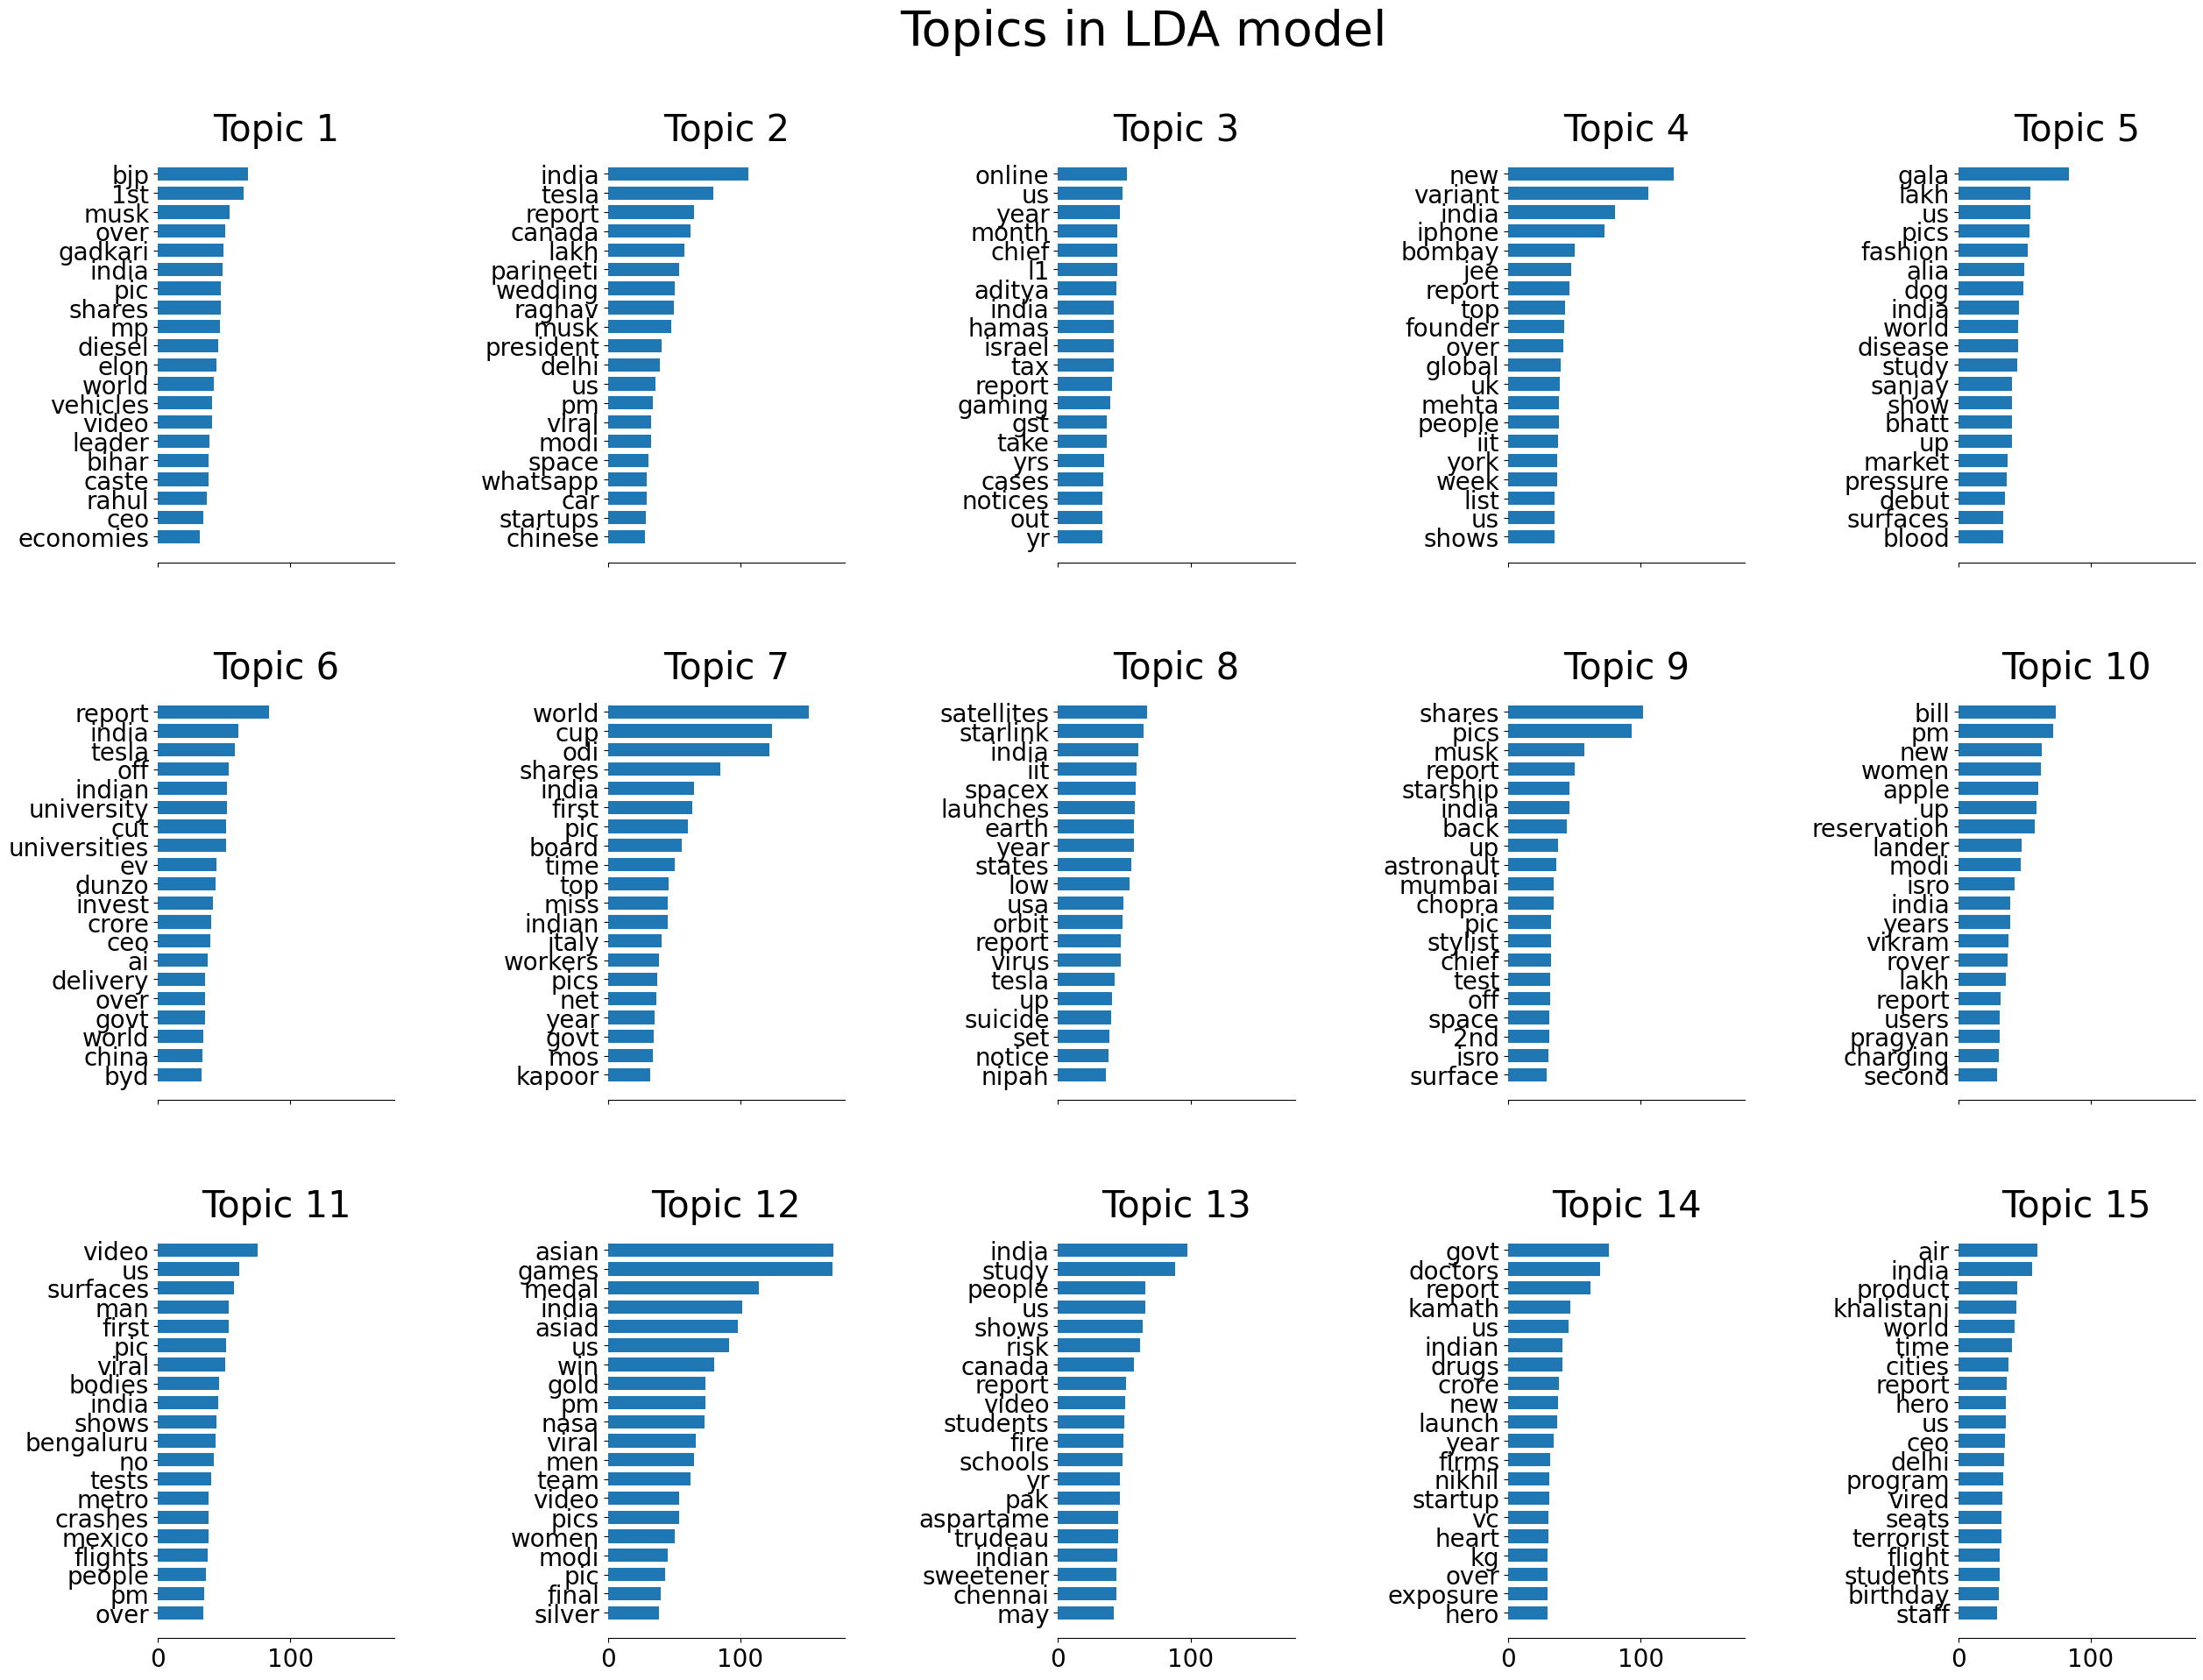

In [10]:
plot_top_words(model=lda, feature_names=tfidf_features, n_top_words=20, title='Topics in LDA model')

Voila we have topics we can see.